In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
from time import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import clear_output

device = 'cuda'

from convolutions import *
from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error
from optimizations import *

# Setup

/home/robert/miniconda3/envs/prdpt/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


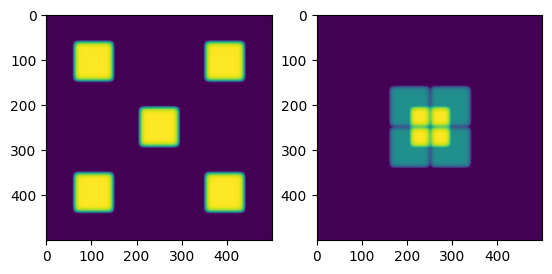

In [3]:
scale = 500
def get_rendering(theta, update_fn=None, ctx_args=None): 
    return draw_rects(theta)

def draw_rect(px, py):   
    s, exp = scale, 10
    w, h = 0.1*s, 0.1*s
    px = max(0+h, min(s-h, px))
    py = max(0+w, min(s-w, py))
    ss = torch.arange(s, device=device)
    x, y = torch.meshgrid(ss, ss)
    image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
    return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)

def reshape_fortran(x, shape):
    '''
    From https://stackoverflow.com/questions/63960352/reshaping-order-in-pytorch-fortran-like-index-ordering/63964246#63964246
    '''
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

def draw_rects(loc_array):
    '''
    loc_array is a 1x2n array for n locations
    '''
    # at least 1 location, and even number of elements
    assert loc_array.shape[0] >= 2
    assert loc_array.shape[0] % 2 == 0
    # first change it to 2xn
    
    twod_loc_array = reshape_fortran(loc_array, (2,-1))
    base_img = draw_rect(twod_loc_array[0,0], twod_loc_array[1,0])
    for i in range(1, twod_loc_array.shape[1]):
        base_img = base_img + draw_rect(twod_loc_array[0,i], twod_loc_array[1,i])
    # base_img = base_img.clamp(0, 1)
    return base_img

def render_smooth(perturbed_theta, gt_img):
  '''
  Michael's code but without the average image
  '''
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, gt_img)
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)
      loss = torch.stack(losses)
  return loss

def logging_box(theta, img_errors, param_errors, i, interval=5, **f_args):
    # plotting, logging, printing...
    theta = theta.squeeze()
    img_curr = get_rendering(theta)
    img_loss = torch.nn.MSELoss()(img_curr, ref_img).item()
    theta_sorted = torch.sort(theta)[0]
    gt_theta_sorted = torch.sort(gt_theta)[0]
    param_loss = torch.nn.MSELoss()(theta_sorted, gt_theta_sorted).item()
    img_errors.append(img_loss)
    param_errors.append(param_loss)
    
    print(f"Iter {i+1} - Img.Loss: {img_loss:.4f} - Param.Loss: {param_loss:.4f}")
    if (i+1) % interval == 0: 
        clear_output(wait=True)
        show_with_error(img_curr, ref_img, iter=i+1)
        plt_errors(img_errors, param_errors, title=f'Iter {i+1}')
    return img_errors, param_errors

n_samples = 10
sigma = 0.1

torch.manual_seed(0)
# set up initial and gt translation:
theta = torch.tensor([0.41,0.41, 0.5,0.5, 0.59,0.59, 0.41,0.59, 0.59,0.41], device=device)*scale
gt_theta = torch.tensor([0.21,0.21, 0.5,0.5, 0.79,0.79, 0.21,0.79, 0.79,0.21], device=device)*scale

init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)

# GT img
plt.subplot(1, 2, 1)
plt.imshow(ref_img.cpu().numpy().squeeze())#, cmap='gray')
# Initial img
plt.subplot(1, 2, 2)
plt.imshow(init_img.cpu().numpy().squeeze())#, cmap='gray')

# individual tests

## CG_HVP

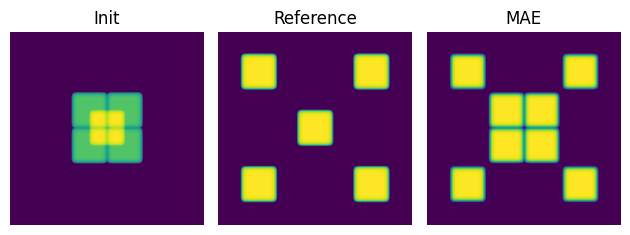

In [56]:
# CG
n_samples = 4
sigma = scale/10
ctx_args = {'nsamples':n_samples}
hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 100, #500
           'anneal_const_first': 20,
           'anneal_const_last': 30, #100
           'anneal_sigma_min': 0.1,
           'tol': 1e-4, # tolerance for CG
           'TR':True,
           'HVP':True,
        #    'aggregate':True,
           'TR_bound': 10,
           'NR_max_iter': 10, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 30, # recompute the exact residual every n iterations
           'conv_thres': 2, # convergence threshold
           'plot_interval':20 # number of iterations to plot
           }


# --------------- run optimization CG
max_iter = hparams['epochs']
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}


In [ ]:
x, _, _, _ = NCG_smooth(render_smooth, theta.clone(), max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=hparams, ctx_args=ctx_args, device=device)
# print(x_list)

## MI(FR22)

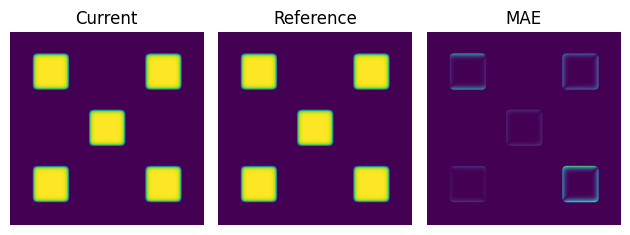

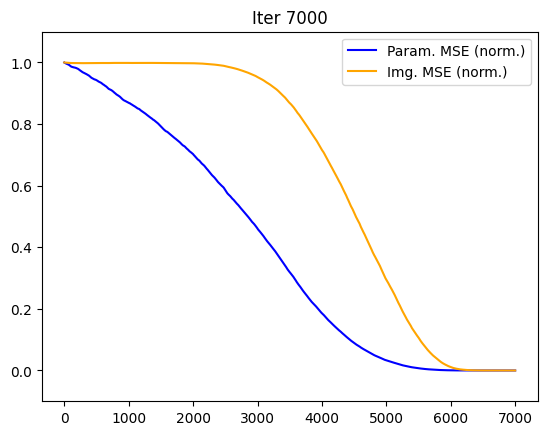

In [54]:
# mi
n_samples = 6
sigma = scale/10
ctx_args = {'nsamples':n_samples}

f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}

mi_box10_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 7000,
           'anneal_const_first': 0,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.1,
           'learning_rate':0.03,
           'plot_interval':100, # number of iterations to plot
           'conv_thres': 5, # convergence threshold
           'tol':1e-8
           }

logging_box(theta.clone(), [], [], 0, 1)

# --------------- run optimization Adam
x, f_loss, param_loss, iter_time = mi_opt(render_smooth, theta.clone(), mi_box10_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
                                           sampler_args=sampler_args, opt_args=mi_box10_hparams, ctx_args=ctx_args, device=device)

## Grad

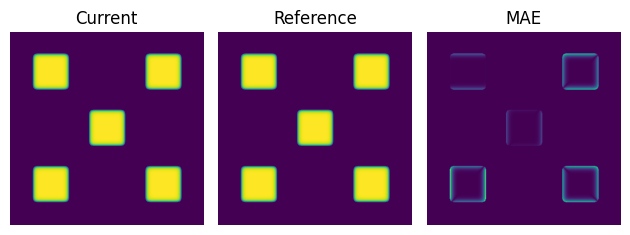

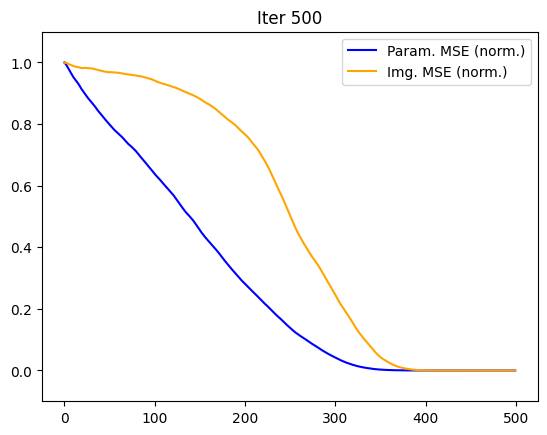

Iter 501 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 502 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 503 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 504 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 505 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 506 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 507 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 508 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 509 - Img.Loss: 0.0000 - Param.Loss: 0.0000


In [240]:
# adam
ctx_args = {'nsamples':n_samples}
adam_box_params = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 100,
           'anneal_const_last': 100,
           'anneal_sigma_min': 0.1,
           'epochs': 700,
           'learning_rate':5e-1,
           'plot_interval':100, # number of iterations to plot
           'tol':1e-6
           }

# --------------- run optimization Adam
max_iter = hparams['epochs']
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x_adam, f_loss, param_loss, iter_time = adam_opt(render_smooth, theta.clone(), adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)

# Batch tests

In [55]:
n_starting_points = 20
starting_points = (torch.rand(n_starting_points, 10, device=device)*0.05 - 0.025)*scale + theta
np.save('./results/box_10d/box_10d_sp.npy', starting_points.cpu())

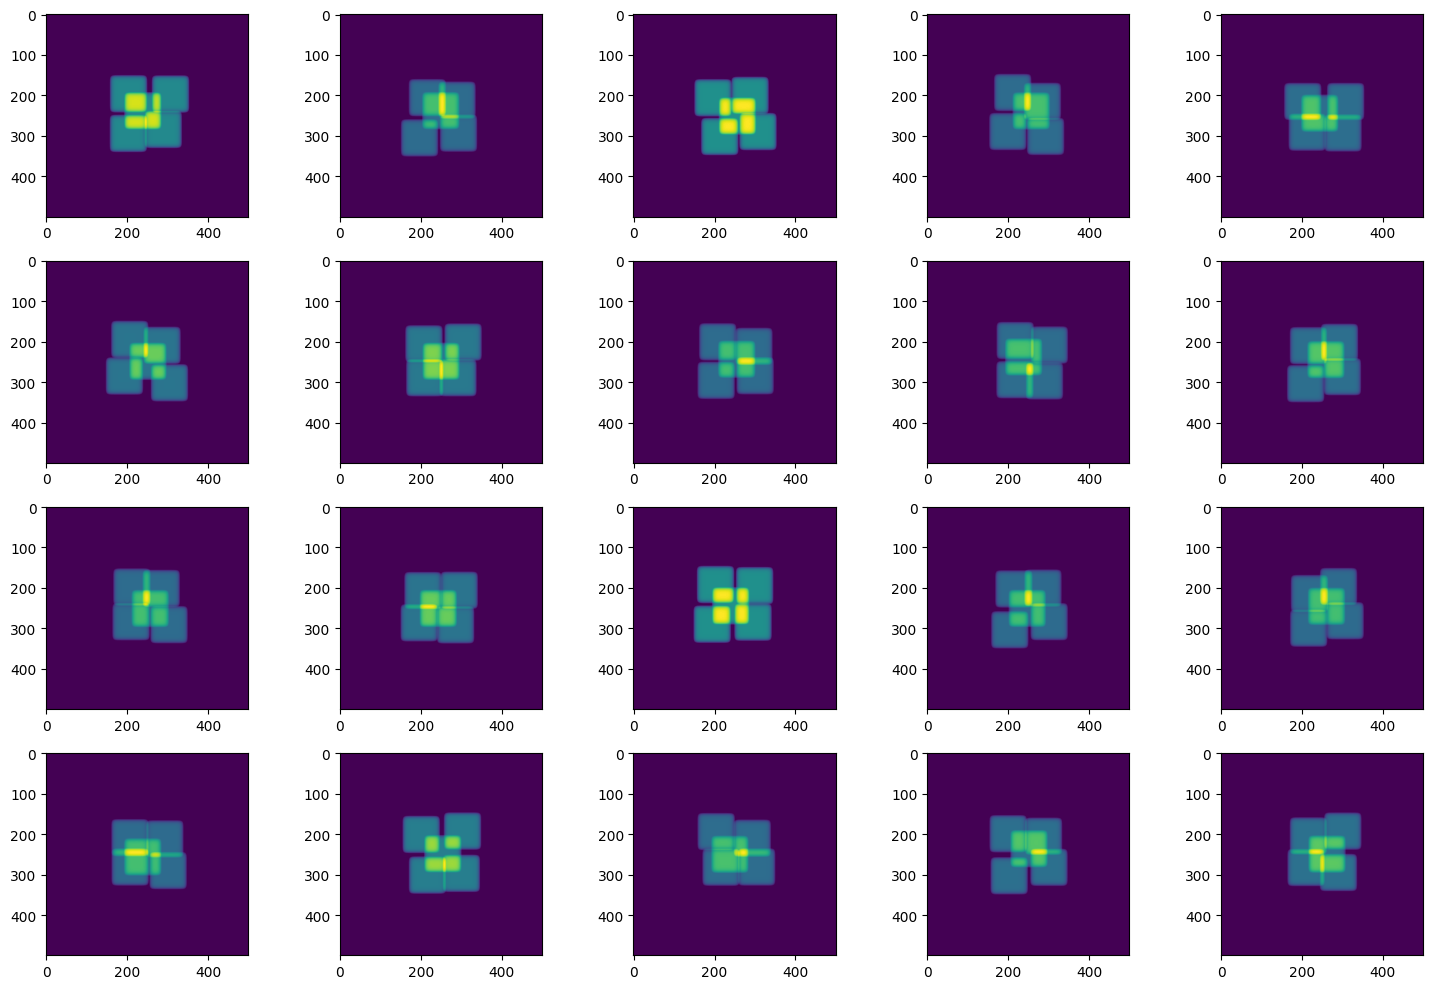

In [9]:
starting_points = np.load('./results/box_10d/box_10d_sp.npy')
starting_points = torch.tensor(starting_points, device=device)
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(draw_rects(starting_points[i]).cpu().squeeze())
plt.tight_layout()

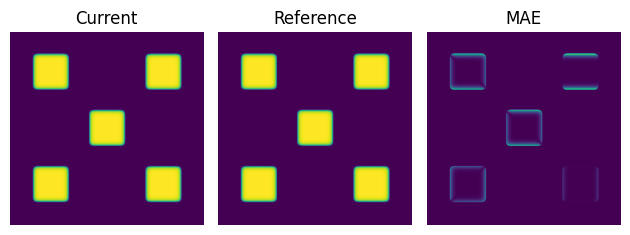

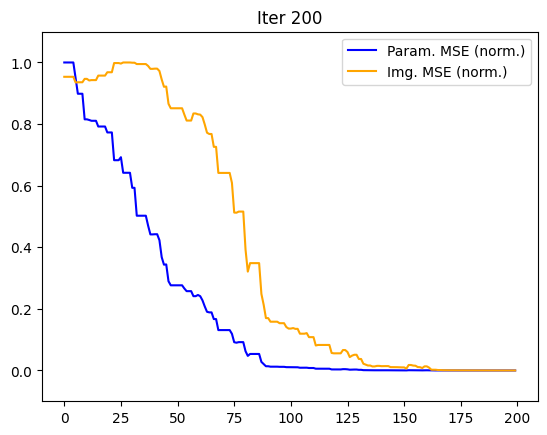

In [352]:
hparams = {'sigma_annealing': True,
           'sigma': scale/6, #/10
           'epochs': 200, #500
           'anneal_const_first': 20, #100
           'anneal_const_last': 10, #50
           'anneal_sigma_min': 0.1,
           'tol': 1e-4, # tolerance for CG
           'TR':True,
           'HVP':False,
        #    'aggregate':True,
           'TR_bound': 10, #0.2
           'NR_max_iter': 3, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 30, # recompute the exact residual every n iterations
           'conv_thres': 2, # convergence threshold
           'plot_interval':10 # number of iterations to plot
           }
for i in range(6, 7):
    theta = starting_points[i]
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization CG
    x_cg, func_loss, param_loss, iter_times = NCG_smooth(render_smooth, theta.clone(), hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=hparams, ctx_args=ctx_args, device=device)
    iter_times = np.insert(iter_times, 0, 0)
    length = len(func_loss)
    for j, loss_i in enumerate(func_loss):
        if loss_i < 0.00002:
            idx = j
            func_loss = func_loss[:idx+1]
            param_loss = param_loss[:idx+1]
            iter_times = iter_times[:idx+1]
    np.save(f'./results/box_10d/box_10d_cg/box_10d_cg_f_loss_{i}.npy', func_loss)
    np.save(f'./results/box_10d/box_10d_cg/box_10d_cg_param_loss_{i}.npy', param_loss)
    np.save(f'./results/box_10d/box_10d_cg/box_10d_cg_times_{i}.npy', iter_times)
    


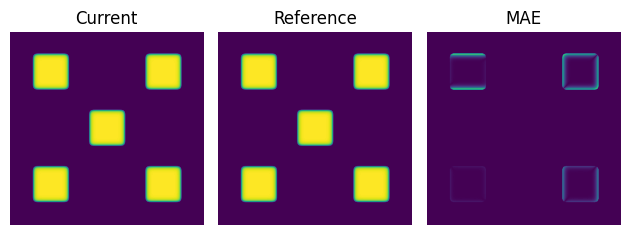

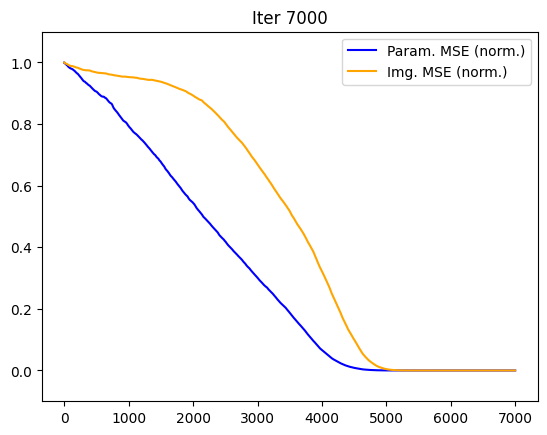

In [65]:
mi_box10_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 7000,
           'anneal_const_first': 2000,
           'anneal_const_last': 500,
           'anneal_sigma_min': 0.1,
           'learning_rate':0.05,
           'plot_interval':100, # number of iterations to plot
           'conv_thres': 5, # convergence threshold
           'tol':1e-8
           }
show_with_error(init_img, ref_img, iter=0)
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization MI
    # time1 = time.time()

    x_mi, func_loss, param_loss, iter_times = mi_opt(render_smooth, theta.clone(), mi_box10_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
                                            sampler_args=sampler_args, opt_args=mi_box10_hparams, ctx_args=ctx_args, device=device)

    length = len(func_loss)
    for j, loss_i in enumerate(func_loss):
        if loss_i < 0.00002:
            idx = j
            func_loss = func_loss[:idx+1]
            param_loss = param_loss[:idx+1]
            iter_times = iter_times[:idx+1]
    np.save(f'./results/box_10d/box_10d_mi/box_10d_mi_f_loss_{i}.npy', func_loss)
    np.save(f'./results/box_10d/box_10d_mi/box_10d_mi_param_loss_{i}.npy', param_loss)
    np.save(f'./results/box_10d/box_10d_mi/box_10d_mi_times_{i}.npy', iter_times)

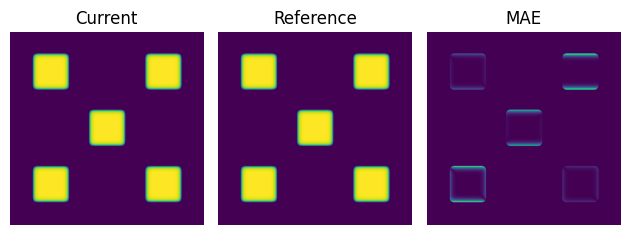

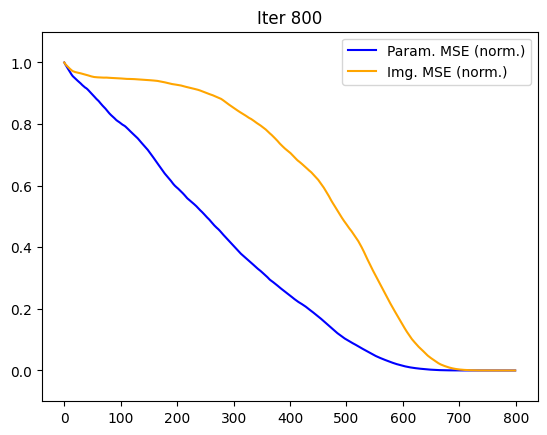

Iter 801 - Img.Loss: 0.0000 - Param.Loss: 0.0007
Iter 802 - Img.Loss: 0.0000 - Param.Loss: 0.0006
Iter 803 - Img.Loss: 0.0000 - Param.Loss: 0.0006
Iter 804 - Img.Loss: 0.0000 - Param.Loss: 0.0006
Iter 805 - Img.Loss: 0.0000 - Param.Loss: 0.0006
Iter 806 - Img.Loss: 0.0000 - Param.Loss: 0.0005
Iter 807 - Img.Loss: 0.0000 - Param.Loss: 0.0005
Iter 808 - Img.Loss: 0.0000 - Param.Loss: 0.0005
Iter 809 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 810 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 811 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 812 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 813 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 814 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 815 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 816 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 817 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 818 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 819 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 820 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 821 - Img.Loss:

In [267]:
adam_box_params = {'sigma_annealing': True,
           'sigma': scale/10,
           'anneal_const_first': 400,
           'anneal_const_last': 50,
           'anneal_sigma_min': 0.1,
           'epochs': 1000,
           'learning_rate':3e-1,
           'plot_interval':100, # number of iterations to plot
           'tol':1e-6
           }
show_with_error(init_img, ref_img, iter=0)
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization Adam
    
    x_adam, func_loss, param_loss, iter_times = adam_opt(render_smooth, theta.clone(), adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                    sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)
    length = len(func_loss)
    for j, loss_i in enumerate(func_loss):
        if loss_i < 0.00025:
            idx = j
            func_loss = func_loss[:idx]
            param_loss = param_loss[:idx]
            iter_times = iter_times[:idx]
    np.save(f'./results/box_10d/box_10d_adam/box_10d_adam_f_loss_{i}.npy', func_loss)
    np.save(f'./results/box_10d/box_10d_adam/box_10d_adam_param_loss_{i}.npy', param_loss)
    np.save(f'./results/box_10d/box_10d_adam/box_10d_adam_times_{i}.npy', iter_times)

# Draw

(351,)
CGHVPAGG bad loss: 
CGHVPAGG median id: 4
CGHVPAGG median time traj: [ 0.          0.60744574  1.21489147  1.82233721  2.42978295  3.03722868
  3.64467442  4.25212015  4.85956589  5.46701163  6.07445736  6.6819031
  7.28934884  7.89679457  8.50424031  9.11168605  9.71913178 10.32657752
 10.93402325 11.54146899 12.14891473 12.75636046 13.3638062  13.97125194
 14.57869767 15.18614341 15.79358915 16.40103488 17.00848062 17.61592635
 18.22337209 18.83081783 19.43826356 20.0457093  20.65315504 21.26060077
 21.86804651 22.47549225 23.08293798 23.69038372 24.29782945 24.90527519
 25.51272093 26.12016666 26.7276124  27.33505814 27.94250387 28.54994961
 29.15739535 29.76484108 30.37228682 30.97973255 31.58717829 32.19462403
 32.80206976 33.4095155  34.01696124 34.62440697 35.23185271 35.83929845
 36.44674418 37.05418992 37.66163565 38.26908139 38.87652713 39.48397286
 40.0914186  40.69886434]
CGHVPAGG median f_loss traj: [2.25289389e-01 2.15420574e-01 2.11724788e-01 2.14098230e-01
 2.139

Text(0.5, 1.0, 'box_10d task optimization(Median of 20 random points)')

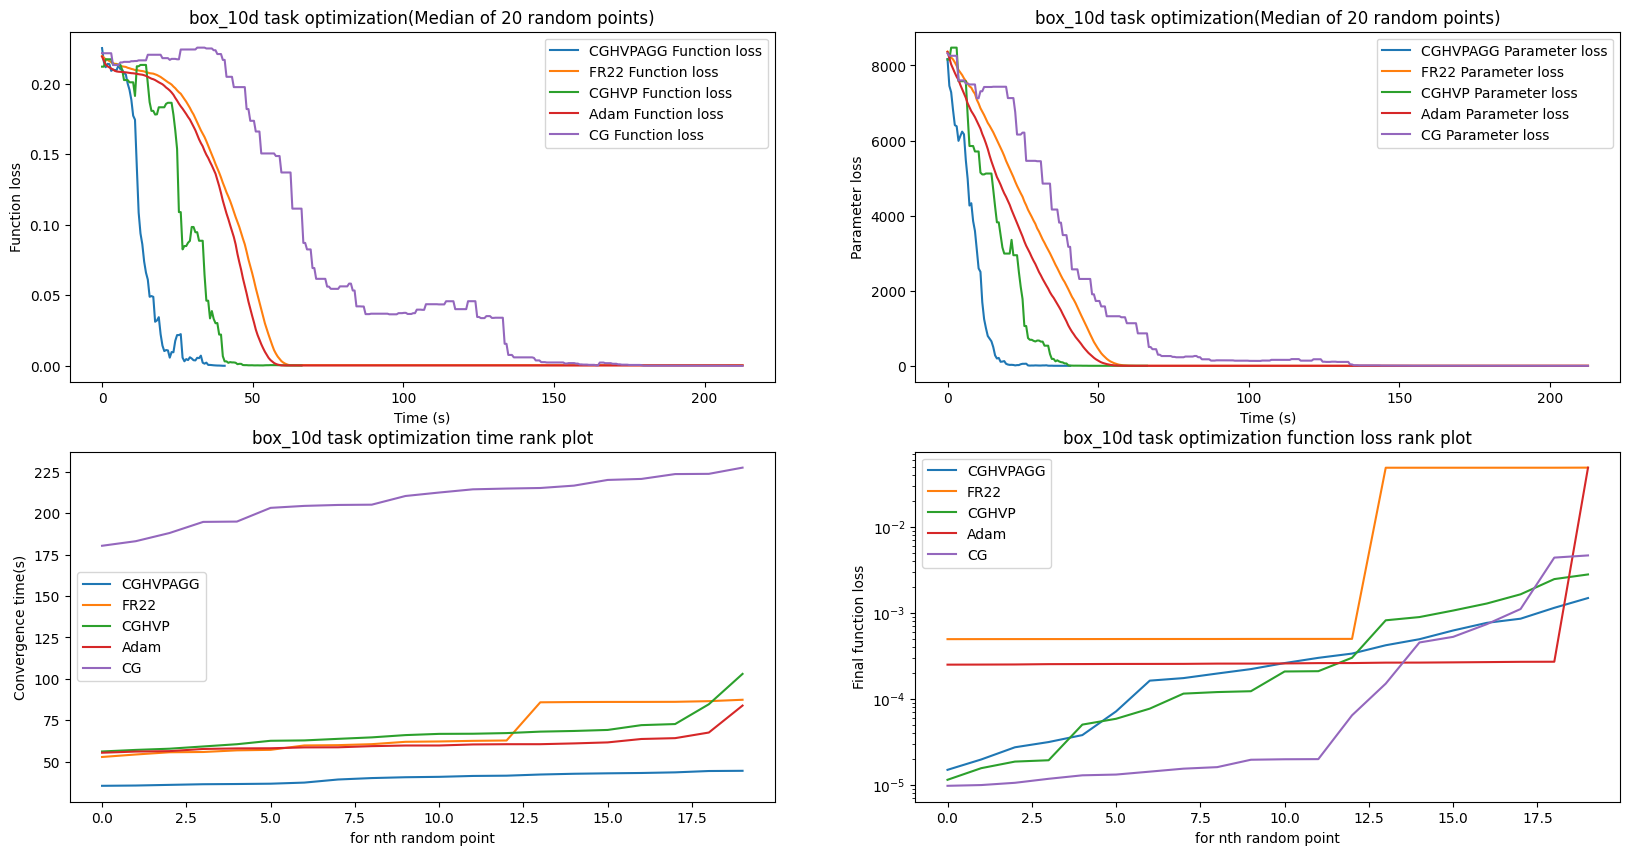

In [353]:
# np.save('potential_loss_hist.npy', loss_hist)
# np.save('potential_time_hist.npy', time_hist)
n_starting_points = 20
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
task = 'box_10d'
path = './results/' + task + '/'
# opts = ['cg', 'mi', 'adam', 'cg_HVP', 'cg_HVP_agg']
# opt_names = ['CG', 'FR22', 'Adam', 'CGHVP', 'CGHVPAGG']
opts = ['cg_HVP_agg', 'mi', 'cg_HVP', 'adam', 'cg']
opt_names = ['CGHVPAGG', 'FR22', 'CGHVP', 'Adam', 'CG']
percentiles = [0.1, 0.01, 1e-3]

final_times = {'final_times_cg':[],
                'final_times_mi': [],
                'final_times_adam': [],
                'final_times_cg_HVP': [],
                'final_times_cg_HVP_agg': []
                }
final_conv = {'final_conv_cg':[],
            'final_conv_mi': [],
            'final_conv_adam': [],
            'final_conv_cg_HVP': [],
            'final_conv_cg_HVP_agg': []
            }

mean_final_times = np.zeros((len(opts), n_starting_points))
mean_f_percentile_times = np.zeros((len(opts), len(percentiles), n_starting_points))
mean_param_percentile_times = np.zeros((len(opts), len(percentiles), n_starting_points))

for i in range(n_starting_points):
    for j in range(len(opts)):
        iter_times = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_times_{i}.npy')
        f_loss = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_f_loss_{i}.npy')
        param_loss = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_param_loss_{i}.npy')
        times = np.cumsum(iter_times)
        
        final_times['final_times_'+opts[j]].append(times[-1])
        final_conv['final_conv_'+opts[j]].append([f_loss[-1].squeeze(), param_loss[-1].squeeze()])
        mean_final_times[j, i] = times[-1] 
        # for percentile time
        for l, percentile in enumerate(percentiles):
            initial_f_error = f_loss[0].squeeze()
            initial_param_error = param_loss[0].squeeze()
            for k, f_error in enumerate(f_loss):
                if f_error <= initial_f_error*percentile:
                    mean_f_percentile_times[j, l, i] = times[k]
                    break
            for k, param_error in enumerate(param_loss.squeeze()):
                if param_error <= initial_param_error*percentile:
                    mean_param_percentile_times[j, l, i] = times[k]
                    break
def round_to_nearest(times, new_times):
    return np.argmin(np.abs(new_times - times))

mean_final_times = mean_final_times.mean(axis=1)
mean_f_percentile_times = mean_f_percentile_times.mean(axis=2)
mean_param_percentile_times = mean_param_percentile_times.mean(axis=2)
median_datasets = []
for i in range(len(opts)):
    median_id = np.argsort(final_times['final_times_'+opts[i]])[len(final_times['final_times_'+opts[i]])//2]
    iter_times = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_times_{median_id}.npy')
    f_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_f_loss_{median_id}.npy')
    param_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_param_loss_{median_id}.npy')
    median_datasets.append({'times': np.cumsum(iter_times), 'f_loss': f_loss, 'param_loss': param_loss})
    
all_times = np.concatenate([d['times'] for d in median_datasets])
global_start, global_end = np.min(all_times), np.max(all_times)
smallest_set = min(median_datasets, key=lambda x: len(x['times']))
smallest_times = smallest_set['times']
average_iter_time = np.mean(np.diff(smallest_times))
new_timestamps = np.arange(global_start, global_end+average_iter_time, average_iter_time)
print(new_timestamps.shape)
new_median_datasets = []
for i, data in enumerate(median_datasets):
    times = data['times']
    # rounded_times = np.unique(rounded_times)
    f_loss_rounded = []
    param_loss_rounded = []
    f_loss_orig = data['f_loss']
    for j, t in enumerate(new_timestamps):
        # print(t)
        # print(times[-1])
        # if t >= times[-1]:
        #     break
        nearest_idx = round_to_nearest(times, t)
        if nearest_idx >= len(f_loss_orig):
            break
        f_loss_rounded.append(f_loss_orig[nearest_idx])
        param_loss_rounded.append(data['param_loss'][nearest_idx])
    f_loss_rounded = np.array(f_loss_rounded)
    param_loss_rounded = abs(np.array(param_loss_rounded))
    new_median_datasets.append({'times': new_timestamps[:len(f_loss_rounded)], 'f_loss': f_loss_rounded, 'param_loss': param_loss_rounded})
    # new_median_datasets[[opts[j]]] = {'times': rounded_times, 'f_loss': f_loss_rounded, 'param_loss': param_loss_rounded}
    

for i in range(len(opts)):
    sorted_conv = np.sort(final_conv['final_conv_'+opts[i]], axis=0)
    sorted_time = np.sort(final_times['final_times_'+opts[i]])
    times = new_median_datasets[i]['times']
    f_loss = new_median_datasets[i]['f_loss']
    param_loss = new_median_datasets[i]['param_loss']
    label_prefix = opt_names[i]
        
    fin_tim = final_times['final_times_'+opts[i]]
    fin_cov = np.array(final_conv['final_conv_'+opts[i]])
    # print(f'{label_prefix} bad: ')
    # for k in range(len(fin_tim)):
    #     if fin_tim[k] > 90:
    #         print(k)
    # print(f'{label_prefix} bad loss: ')
    # # print(fin_cov[:,0])
    # for k in range(len(fin_cov)):
    #     if abs(fin_cov)[k,0] > 0.005:
    #         print(k)
    with np.printoptions(threshold=np.inf):
        print(f'{label_prefix} median id: {median_id}')
        print(f'{label_prefix} median time traj: {times}')
        print(f'{label_prefix} median f_loss traj: {f_loss}')
        print(f'{label_prefix} median param_loss traj: {param_loss}')
        print(f'{label_prefix} average time: {mean_final_times[i]}')
    for j in range(len(percentiles)):
        print(f'{label_prefix} average time for {percentiles[j]} percentile in function loss: {mean_f_percentile_times[i, j]}')
        print(f'{label_prefix} average time for {percentiles[j]} percentile in parameter loss: {mean_param_percentile_times[i, j]}')
    
    ax[0,0].plot(times, f_loss, label=label_prefix + ' Function loss')
    ax[0,1].plot(times, param_loss.squeeze(), label=label_prefix+' Parameter loss')
    print(f'{label_prefix} convergence times: {sorted_time}')
    print(f'{label_prefix} convergence function loss: {np.abs(sorted_conv[:,0])}')
    print(f'{label_prefix} convergence parameter loss: {np.abs(sorted_conv[:,1])}')
    ax[1,0].plot(sorted_time, label=label_prefix)
    ax[1,1].plot(sorted_conv[:,0], label=label_prefix)
    
ax[1,0].set_xlabel('for nth random point')
ax[1,0].set_ylabel('Convergence time(s)')
ax[1,0].set_title(f'{task} task optimization time rank plot')
ax[1,0].legend()

ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('for nth random point')
ax[1,1].set_ylabel('Final function loss')
ax[1,1].set_title(f'{task} task optimization function loss rank plot')
ax[1,1].legend()

ax[0,0].legend()
ax[0,1].legend()
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Function loss')
ax[0,0].set_title(f'{task} task optimization(Median of {n_starting_points} random points)')
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Parameter loss')
ax[0,1].set_title(f'{task} task optimization(Median of {n_starting_points} random points)')
# save_path = './results/' + task + '/' + task + '_task.pdf'
# plt.savefig(save_path, format='pdf')
# ax[0,0].set_yscale('log')
# ax[0,1].set_yscale('log')
# save_path = './results/' + task + '/' + task + '_task_log.pdf'
# plt.savefig(save_path, format='pdf') 